In [ ]:
import os
import shutil

base_dir = "/content/tiny-imagenet-200"
val_dir = os.path.join(base_dir, "val")
images_dir = os.path.join(val_dir, "images")
ann_file = os.path.join(val_dir, "val_annotations.txt")

# Read annotations
with open(ann_file) as f:
    annotations = [line.strip().split('\t') for line in f]

# Create class folders and move images
for img, cls, *_ in annotations:
    cls_dir = os.path.join(val_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)
    shutil.move(
        os.path.join(images_dir, img),
        os.path.join(cls_dir, img)
    )

os.rmdir(images_dir)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfla
import tensorflow.keras.models as tfm
import tensorflow.keras.optimizers as tfo
import tensorflow.keras.losses as tflo
import matplotlib.pyplot as plt

In [ ]:
# load training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/train",
    image_size=(224, 224),
    batch_size=128,
    label_mode="int"
)

# load test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/val",
    image_size=(224, 224),
    batch_size=128,
    label_mode="int"
)

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


In [ ]:
def compute_mean(dataset):
  total = tf.zeros([3], dtype=tf.float32)
  count = 0

  for images, _ in dataset:
    images = tf.cast(images, tf.float32)
    pixels = tf.reshape(images, [-1, 3])
    total += tf.reduce_sum(pixels, axis=0)
    count += tf.shape(pixels)[0]

  return total / tf.cast(count, tf.float32)

In [ ]:
mean = compute_mean(train_ds)
train_ds = train_ds.map(lambda x, y: (x - mean, y))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x - mean, y))
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
bias_init = tf.keras.initializers.Zeros()

In [ ]:
inputs = tfla.Input(shape=(224, 224, 3))

# conv block 1
x = tfla.Conv2D(64, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(inputs)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

# conv block 2
x = tfla.Conv2D(128, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

# conv block 3
x = tfla.Conv2D(256, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(256, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

# conv block 4
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

# conv block 5
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

x = tfla.Flatten()(x)

# FC 6
x = tfla.Dense(4096, activation="relu", kernel_initializer=kernel_init,
                bias_initializer=bias_init)(x)
x = tfla.Dropout(0.3)(x)

# FC 7
x = tfla.Dense(4096, activation="relu", kernel_initializer=kernel_init,
                bias_initializer=bias_init)(x)
x = tfla.Dropout(0.3)(x)

#FC 8
outputs = tfla.Dense(200, kernel_initializer=kernel_init,
                bias_initializer=bias_init)(x)

model = tfm.Model(inputs, outputs)

In [ ]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.9,
    weight_decay=5e-4,
)

model.compile(
    optimizer=optimizer,
    loss=tflo.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
def lr_schedule(epoch, lr):
  if(epoch < 20):
    return 0.001
  else:
    if(epoch < 40):
      return 0.0001
    else:
      if(epoch < 60):
        return 0.00001
      else:
        return 0.000001

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 28, 28, 512)    │             

 Total params: 129,596,744 (494.37 MB)

 Trainable params: 129,591,240 (494.35 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [ ]:
images, labels = next(iter(train_ds))

with tf.GradientTape() as tape:
  preds = model(images, training=True)
  loss = model.compiled_loss(labels, preds)

grads = tape.gradient(loss, model.trainable_weights)

for var, grad in zip(model.trainable_weights, grads):
  print(var.name, grad)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:671: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


kernel tf.Tensor(
[[[[-1.56943023e-01  1.58611447e-01  5.89120910e-02 ...  2.82095015e-01
     8.11076835e-02 -1.48621947e-02]
   [-3.22562039e-01  3.16723496e-01 -1.44978315e-01 ...  4.10816431e-01
    -7.15203136e-02  3.86296250e-02]
   [-3.66056412e-01  3.00378412e-01 -6.09198511e-02 ...  3.00782979e-01
     8.67182463e-02  3.62031497e-02]]

  [[-2.30601043e-01  1.36548579e-01 -1.68213397e-02 ...  1.70414969e-01
    -5.51205762e-02 -3.96927223e-02]
   [-3.99349928e-01  2.90701807e-01 -2.20283628e-01 ...  2.98011214e-01
    -2.37336457e-01  1.00794099e-02]
   [-4.15989190e-01  2.88681984e-01 -1.35963634e-01 ...  2.15062857e-01
    -8.02726150e-02 -2.93421093e-04]]

  [[ 1.10511974e-01  8.52751061e-02 -3.02106142e-04 ...  1.53177068e-01
     2.17281848e-01 -3.32931988e-04]
   [-8.07741806e-02  2.35989809e-01 -2.09643766e-01 ...  2.64821470e-01
    -2.49541346e-02  4.84065227e-02]
   [-1.15698710e-01  2.44292170e-01 -1.29709974e-01 ...  1.88024223e-01
     7.56313205e-02  2.84420308e-0

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history = model.fit(
    train_ds,
    epochs=40,
    callbacks=[lr_callback]
)

print("\nevaluation\n")
model.evaluate(test_ds)

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 554s 632ms/step - accuracy: 0.0270 - loss: 5.0839 - learning_rate: 0.0010
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 473s 605ms/step - accuracy: 0.1144 - loss: 4.2209 - learning_rate: 0.0010
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 474s 606ms/step - accuracy: 0.1857 - loss: 3.6875 - learning_rate: 0.0010
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 474s 606ms/step - accuracy: 0.2430 - loss: 3.3537 - learning_rate: 0.0010
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 474s 606ms/step - accuracy: 0.2857 - loss: 3.1078 - learning_rate: 0.0010
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 474s 606ms/step - accuracy: 0.3248 - loss: 2.8935 - learning_rate: 0.0010
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 474s 606ms/step - accuracy: 0.3623 - loss: 2.6963 - learning_rate: 0.0010
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 474s 607ms/step - accuracy: 0.3988 - loss: 2.5057 - learning_rate: 0.0010
Epoch 9/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 474s 606ms/step - accuracy: 0.4350 - loss: 2.333

[2.8426573276519775, 0.4311000108718872]

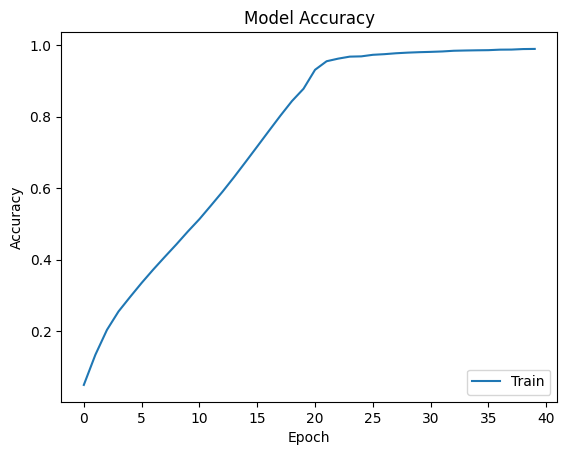

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [ ]:
model.save_weights("vgg11.weights.h5")